# Preâmbulo

Import e funções básicas

In [ ]:
! wget https://www.dropbox.com/s/83ob8ibibsjdkwt/data.zip
! unzip data.zip

--2021-02-17 12:23:57--  https://www.dropbox.com/s/83ob8ibibsjdkwt/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/83ob8ibibsjdkwt/data.zip [following]
--2021-02-17 12:23:57--  https://www.dropbox.com/s/raw/83ob8ibibsjdkwt/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2f8e47e47fce91e472b52c0352.dl.dropboxusercontent.com/cd/0/inline/BJEvb1wgX0BgxdyklS9BSZzuQY3ENUTC3EKSC1q-5XIxl8q2w0LiA0ORZ5Kb-PgXPKGizXfg4Qd858sBzIK-uwqz6-Bxv0dGcvzVvh5Qj7fUFAb-i5F2mlqxX9eev3uV8KI/file# [following]
--2021-02-17 12:23:57--  https://uc2f8e47e47fce91e472b52c0352.dl.dropboxusercontent.com/cd/0/inline/BJEvb1wgX0BgxdyklS9BSZzuQY3ENUTC3EKSC1q-5XIxl8q2w0LiA0ORZ5Kb-PgXPKGizXfg4Qd858sBzIK-uwqz6-Bxv0dGcvzVvh5Qj7fUFAb-i5F2mlqxX9e

In [1]:
import torch
from torchvision import transforms, datasets

### Other image libraries ###
import PIL
from PIL import Image, ImageFilter, ImageDraw
from skimage import util, transform, filters, data, morphology 
from scipy import ndimage as ndi
##############################

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# Kill axis on plot
matplotlib.rc('axes.spines',top=False,bottom=False,left=False,right=False);
matplotlib.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
matplotlib.rc(('xtick','ytick'),color=(1,1,1,0));

# Setting predefined arguments.
args = {
    'w_size': 224,        # Width size for image resizing.
    'h_size': 224,        # Height size for image resizing.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


# Digital Image Processing

## Data Augmentation with `torchvision`

Torchvision is closely related to an image library called `Pillow`. If you check [the documentation](https://pytorch.org/docs/stable/torchvision/transforms.html) of Torchvision's `transform`, the expected input is a `PIL` object, provided by `Pillow`.

It is importanto to get to know this library a little as well as other libraries (such as `skimage`), since Torchvision's `transforms` provide only a few basic transformations.

In [ ]:
img_transform = transforms.Compose( [ transforms.Resize((args['h_size'], args['w_size'])),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30, resample=PIL.Image.BILINEAR),
                                      transforms.ToTensor()])


dataset = datasets.ImageFolder('./data/classification/', transform=img_transform)

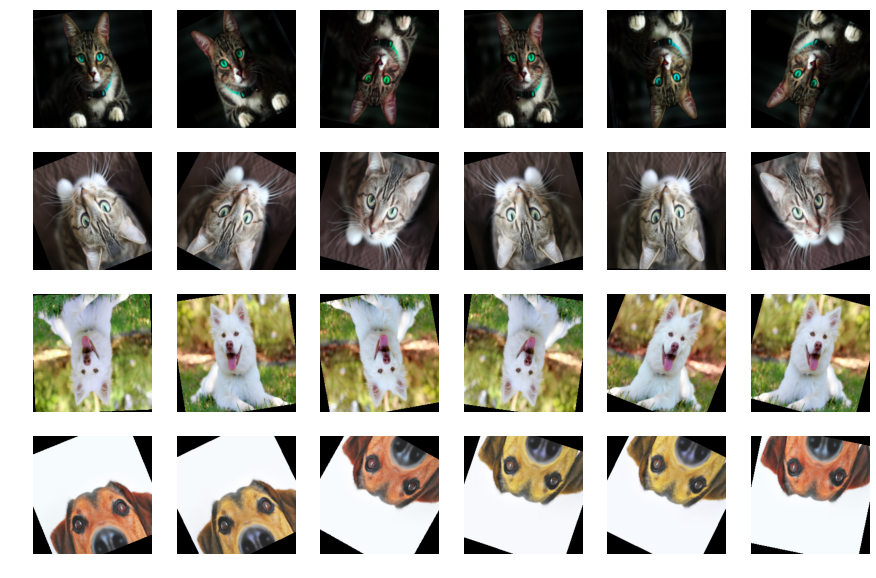

In [ ]:
repeat_load = 6
fig, axs = plt.subplots(len(dataset), repeat_load , figsize=(15, 10))

for k in range(len(dataset)):

  for i in range(repeat_load):
    ## Loading and transforms performed on demand
    img, target = dataset[k] 
    axs[k, i].imshow(img.permute(1,2,0))
  


## Other Image Libraries

In order to explore different image libraries for more refined transformations, one can create custom transformation classes. It consists in a common object class, containing a `__call__(self, img)` function with the required set of traisnformations.

```python
class ImgTransform(object):
  def __call__(self, img):
    ### Set of transforms over img ###
    ### Remember to always return a tensor :)
    img = transforms.ToTensor()(img)
    return img
```

The main image libraries with useful transform functions are:

**Pillow**
* Pillow `Image` documentation: https://pillow.readthedocs.io/en/stable/reference/Image.html
* Pillow `ImageFilter` documentation:

**Scikit-Image**
* `skimage.transform`: https://scikit-image.org/docs/dev/api/skimage.transform.html
* `skimage.util`: https://scikit-image.org/docs/dev/api/skimage.util.html

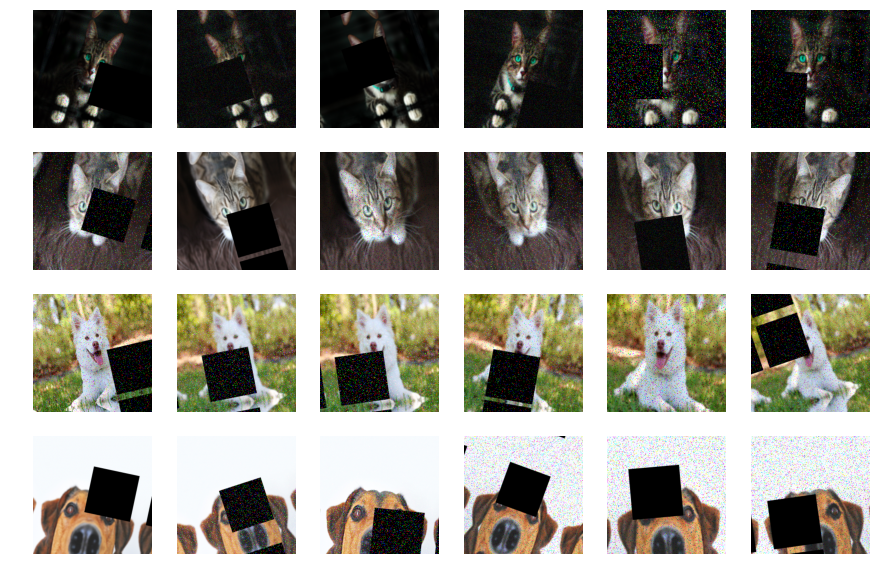

In [ ]:
class ImgTransform(object):

    def __init__(self):
      self.square = Image.open('./data/square.png')
      self.noises = ['gaussian', 'salt', 'pepper', 's&p']
      self.prob = 0.2
    
    def __call__(self, img):
        img = transforms.Resize((args['h_size'], args['w_size']))(img)
        img = transforms.RandomHorizontalFlip()(img)
        
        ### Sharpen Image
        if np.random.random() > self.prob:
          img = img.filter(ImageFilter.SHARPEN)

        ### Gaussian Blur
        if np.random.random() > self.prob:
          img = img.filter(ImageFilter.GaussianBlur(1))

        ### Add occlusions
        if np.random.random() > self.prob:
          x0 = np.random.choice(range(args['w_size']-50)) 
          y0 = np.random.choice(range(args['h_size']-50)) 

          img.paste(self.square, (x0, y0))

        ###### PIL OBJECT BEFORE CONVERTING ###### 

        img = np.asarray(img)

        ###### SKIMAGE HANDLES NUMPY ARRAYS OR TENSOR OBJECTS ######

        ### Rotations with reflect (how to fill empty borders)
        if np.random.random() > self.prob:
          img = transform.rotate(img, np.random.choice(range(-20,20)), mode='symmetric', resize=True)

        ### Add noise to image (see list at __init__())
        if np.random.random() > self.prob:
          img = util.random_noise( img, mode=np.random.choice(self.noises) )
          
        ### Remember to always return a tensor :)
        img = transforms.ToTensor()(img)
        return img


dataset = datasets.ImageFolder('./data/classification/', transform=ImgTransform())

repeat_load = 6
fig, axs = plt.subplots(len(dataset), repeat_load , figsize=(15, 10))

for k in range(len(dataset)):

  for i in range(repeat_load):
    ## Loading and transforms performed on demand
    img, target = dataset[k] 
    axs[k, i].imshow(img.permute(1,2,0))
  


## Semantic Segmentation

Fine-grained detection of "objects" (any subject of interest) in an image. The process is intended to output a pixel-wise mask marking the location of desired objects. Segmenting an image is basically a pixel-wise classification, also known as **dense labeling** as opposed to sparse labeling of a regular image classification task. <br><br>

![](https://www.dropbox.com/s/ukp0gtr0eph94cv/masks.png?dl=1)

### Threshold-based Segmentation

Simplest method of segmentation. It consistis in finding a threshold that divides pixel intensisties from a given image (grayscale) in light versus dark.



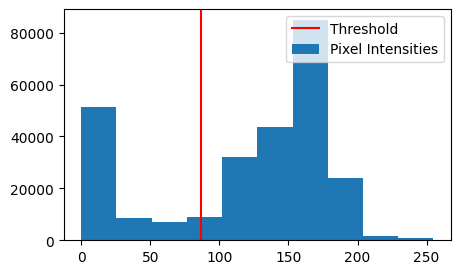

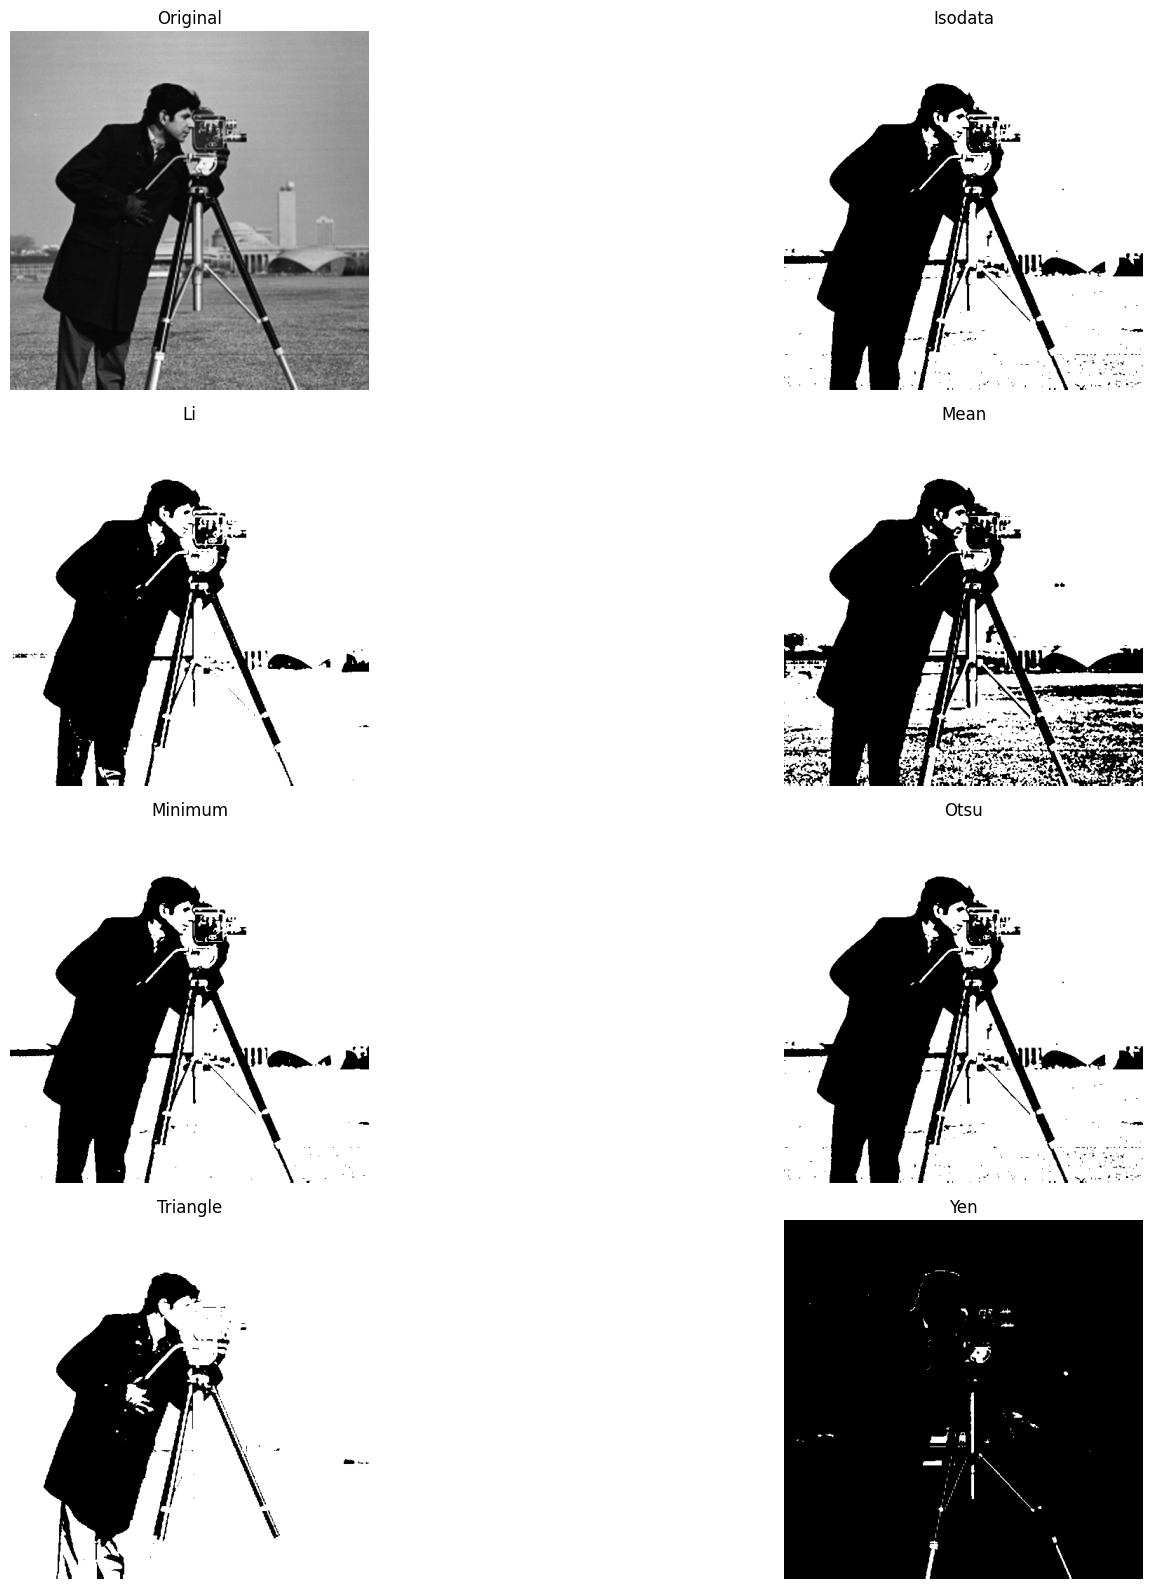

In [ ]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# img = data.page()
img = data.camera()
# img = data.coins()

### Let us look at the threshold from a single method (Otsu)
flat_img = np.reshape(img, img.shape[0]*img.shape[1])
fig, axs = plt.subplots(figsize=(5, 3))
axs.hist(flat_img, label='Pixel Intensities')
threshold = filters.threshold_otsu(flat_img)
axs.axvline(threshold, 0, 1, color='r', label='Threshold')
axs.legend()

### Now let's see the binary transformation from multiple methods
fig, ax = filters.try_all_threshold(img, figsize=(20, 16), verbose=False)
plt.show()

### Morphology post-processing

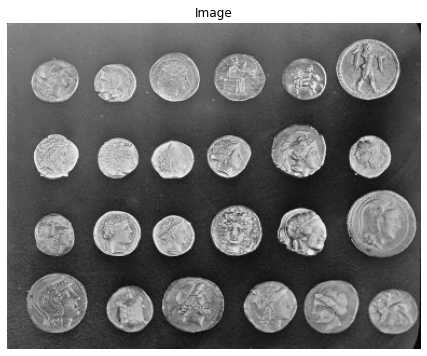

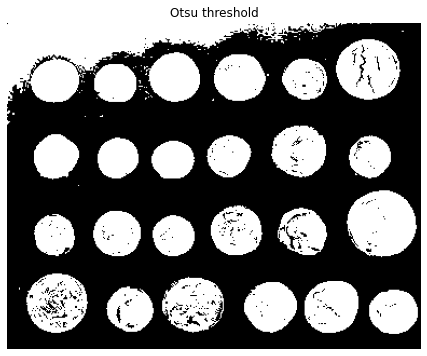

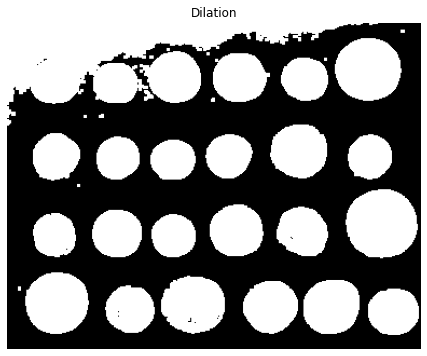

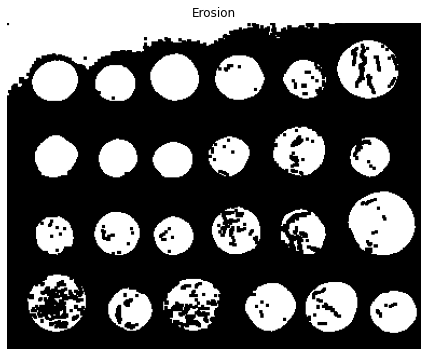

In [84]:
img = data.coins()
show(img, 'Image')

thresh = filters.threshold_otsu(img)
binary = img > thresh
show(binary, title='Otsu threshold')

out = morphology.dilation(binary, morphology.square(3))
show(out, title='Dilation')

out = morphology.erosion(binary, morphology.square(3))
show(out, title='Erosion')

## SLIC and Graph-cut

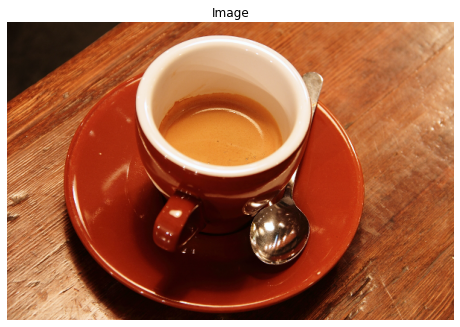

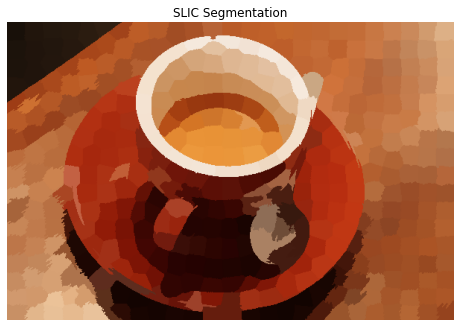

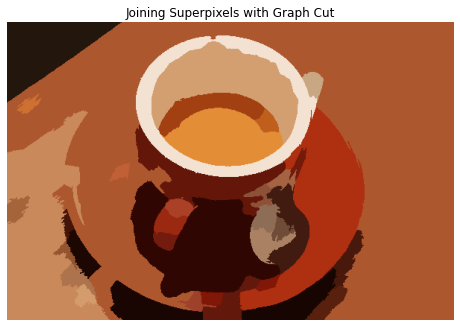

In [29]:
from skimage import segmentation, color
from skimage.future import graph

img = data.coffee()

# Computing SLIC
labels1 = segmentation.slic(img, compactness=30, n_segments=400)
slic_output = color.label2rgb(labels1, img, kind='avg')

# Computing adjacency graph using mean colors
g = graph.rag_mean_color(img, labels1)

# Graph cut vertices > threshold
labels2 = graph.cut_threshold(labels1, g, 29)
cut_output = color.label2rgb(labels2, img, kind='avg')

show(img, title='Image')
show(slic_output, title='SLIC Segmentation')
show(cut_output, 'Joining Superpixels with Graph Cut')


### Watershed Segmentation

It performs instance segmentation based on predefined markers. <br>
Markers can be automatically predefined as low gradient regions, as implemented below.

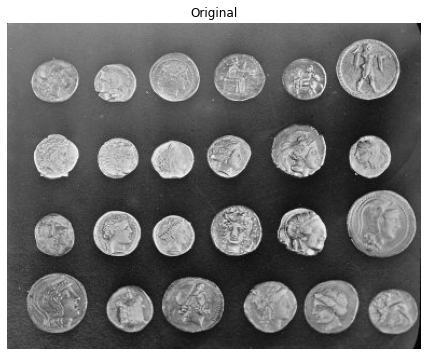

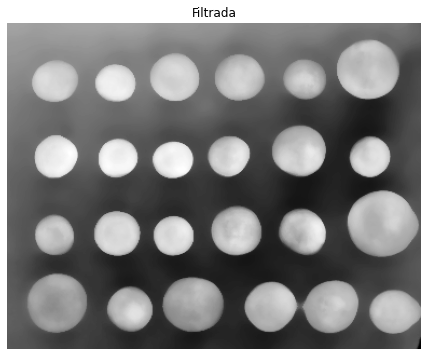

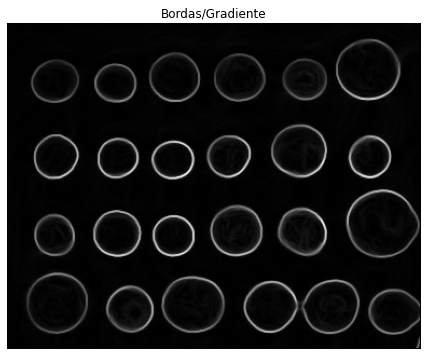

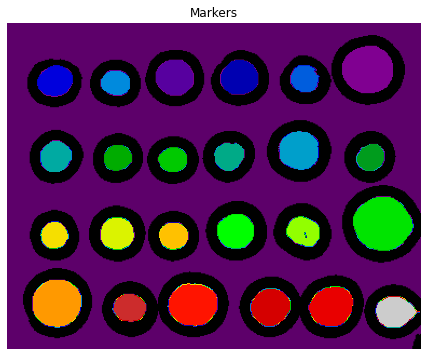

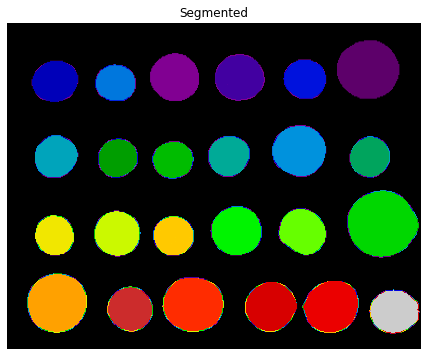

In [10]:
def show(img, title='', cmap=None):
    cmap = cmap or plt.cm.gray
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(img, cmap=cmap)
    ax.set(title=title)
    ax.set_axis_off()
    plt.show()

img = data.coins()

image = util.img_as_ubyte(img)

# Reducing the noise with a median filter
denoised = filters.rank.median(image, morphology.disk(9))

# Markers: Homogenous regions (low gradient)
markers = filters.rank.gradient(denoised, morphology.disk(5)) < 40
markers = ndi.label(markers)[0]

# Detecting edges (local gradients)
gradient = filters.sobel(denoised)

# Computes watershed based on edge image and automatically predefined markers.
labels = morphology.watershed(gradient, markers)

show(image,    title="Original")
show(denoised, title="Filtrada")
show(gradient, title="Bordas/Gradiente")
show(markers,  title="Markers",   cmap=plt.cm.nipy_spectral)
show(labels,   title="Segmented", cmap=plt.cm.nipy_spectral)

Function `regionprobs()` from scikit-image compute measures over label images as the one we previously built. Ex.: Bounding box, area, centroid, convex image, etc.

See more: https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

There are 37 coins


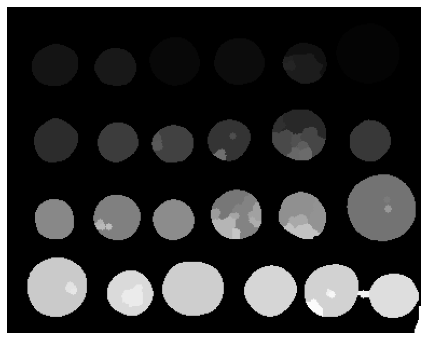

In [37]:
from skimage.measure import regionprops

regions = regionprops(labels)

# Bounding boxes for regions > 100 pixels
boxes = np.array([label['BoundingBox']
                  for label in regions
                  if label['Area'] > 100])

print(f'There are {len(boxes)-1} coins')
show(labels)

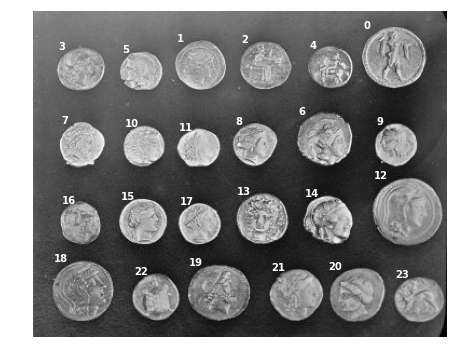

In [28]:
img = data.coins()
plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')

for k,box in enumerate(boxes[1:]):
  x0, y0, x1, y1 = box
  plt.text( y0, x0, str(k), color='w', fontweight='bold' ) 
plt.show()

## Exercise

Given samples from Aedis Aegypt eggs (see links below), implement a segmentation approach to **count the eggs**. Feel free to explore multiple approaches we previously covered.

> Note that pre-processing and/or post-processing are valuable steps for the task of segmentation. 

Samples:

* https://www.dropbox.com/s/fpvoobhe5vg60g8/palheta_cartao02.png?dl=1
* https://www.dropbox.com/s/z9l7obnzdc380dr/ovos_aedes-02.jpg?dl=1
* https://www.dropbox.com/s/wlf48u0dkvvqpwo/palheta_cartao01.png?dl=1

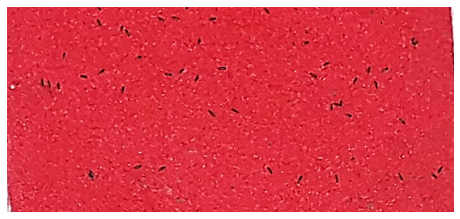

In [82]:
from skimage import io

img = io.imread('https://www.dropbox.com/s/fpvoobhe5vg60g8/palheta_cartao02.png?dl=1')
show(img)